# CNN + MaxPool
CNN with GenCode 43 data.
Merge cell lines using average of the antilogs.
Ten rounds of CV.
Use class_weights for balanced predictions.
Return to 3 epochs of training.

Analyze effect of removing the middle.
Filter train set = False.
Filter valid set = False.

TO DO:
* Retain best model.

In [43]:
from datetime import datetime
print(datetime.now())

2023-03-06 23:58:49.543759


In [44]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [45]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.8.10
sklearn 1.2.1


In [46]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.canon_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [47]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [48]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [49]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [50]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-06 23:58:52.275088
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [51]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                next_index += 1
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # As in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self):
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index,False) # exclude middle
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index,False)  # exclude middle
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None
            cw = class_weight.compute_class_weight(
                'balanced', classes=[0,1], y=y_train)
            cwd = {0: cw[0], 1: cw[1]}

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
                validation_data=(X_valid,y_valid) ) #class_weight=cwd,
            
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-06 23:58:52.509521
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.
Cross validation...
2023-03-06 23:59:00.533232
splitting
Fold 1
Discriminator ZERO -1
FIT
2023-03-06 23:59:01.706942
PREDICT
2023-03-06 23:59:07.772974
train class weights 1:0  0.58: 3.58
Train 1:0 2915:473 86.04%
Valid 1:0 733:115 86.44%
Predict 1:0 848:0 100.00%


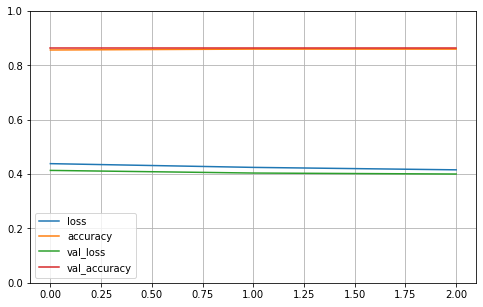

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.64857674 to 0.9689892
Score threshold 0.5


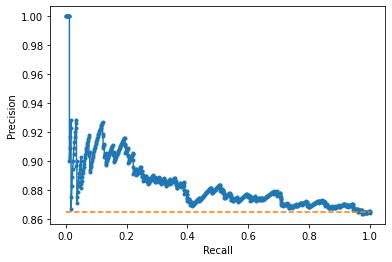

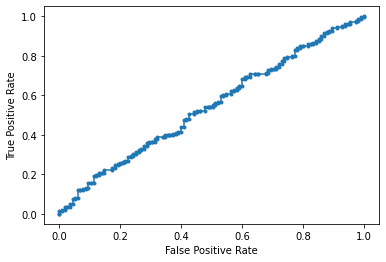

Accuracy: 86.44% Precision: 86.44% Recall: 100.00%
F1: 92.73% MCC: 0.00%
AUPRC: 88.34% AUROC: 54.38%
2023-03-06 23:59:08.932556
Fold 2
Discriminator ZERO -1
FIT
2023-03-06 23:59:12.017646
PREDICT
2023-03-06 23:59:18.292835
train class weights 1:0  0.58: 3.57
Train 1:0 2915:474 86.01%
Valid 1:0 733:114 86.54%
Predict 1:0 847:0 100.00%


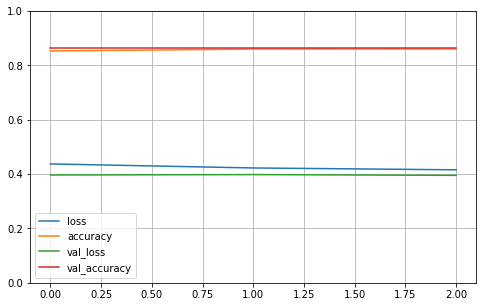

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.68932676 to 0.98138636
Score threshold 0.5


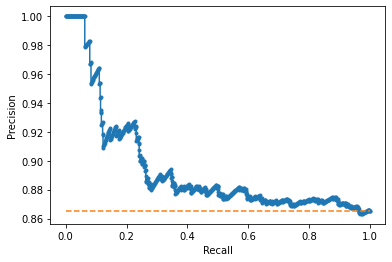

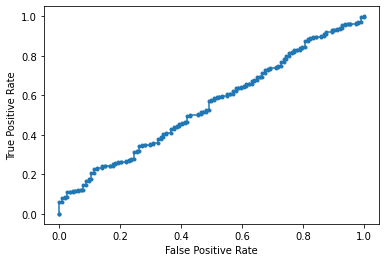

Accuracy: 86.54% Precision: 86.54% Recall: 100.00%
F1: 92.78% MCC: 0.00%
AUPRC: 89.44% AUROC: 55.03%
2023-03-06 23:59:19.232004
Fold 3
Discriminator ZERO -1
FIT
2023-03-06 23:59:22.132527
PREDICT
2023-03-06 23:59:28.380066
train class weights 1:0  0.58: 3.56
Train 1:0 2913:476 85.95%
Valid 1:0 735:112 86.78%
Predict 1:0 847:0 100.00%


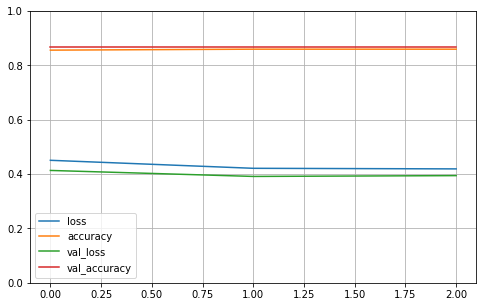

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.71375036 to 0.92968035
Score threshold 0.5


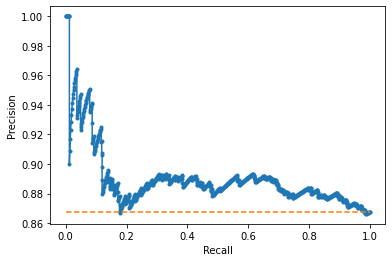

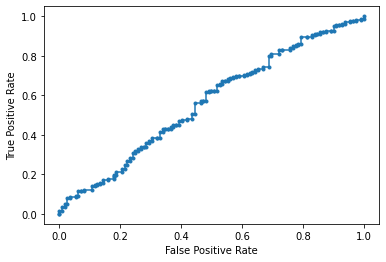

Accuracy: 86.78% Precision: 86.78% Recall: 100.00%
F1: 92.92% MCC: 0.00%
AUPRC: 88.99% AUROC: 56.27%
2023-03-06 23:59:29.293554
Fold 4
Discriminator ZERO -1
FIT
2023-03-06 23:59:31.823574
PREDICT
2023-03-06 23:59:38.111139
train class weights 1:0  0.58: 3.64
Train 1:0 2924:465 86.28%
Valid 1:0 724:123 85.48%
Predict 1:0 847:0 100.00%


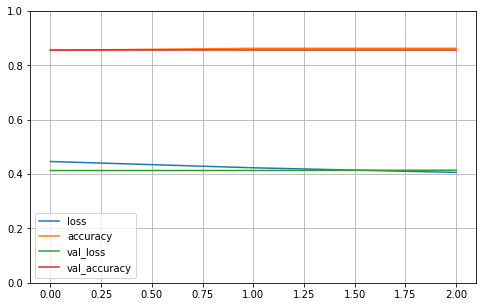

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.6490908 to 0.97863984
Score threshold 0.5


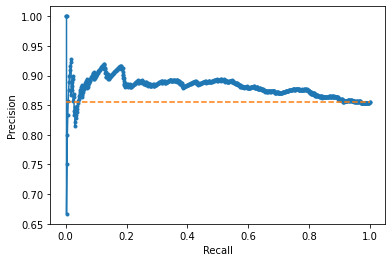

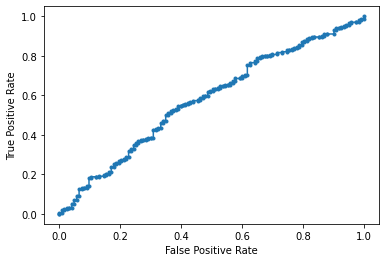

Accuracy: 85.48% Precision: 85.48% Recall: 100.00%
F1: 92.17% MCC: 0.00%
AUPRC: 88.05% AUROC: 57.83%
2023-03-06 23:59:39.101463
Fold 5
Discriminator ZERO -1
FIT
2023-03-06 23:59:41.684581
PREDICT
2023-03-06 23:59:47.976418
train class weights 1:0  0.58: 3.65
Train 1:0 2925:464 86.31%
Valid 1:0 723:124 85.36%
Predict 1:0 847:0 100.00%


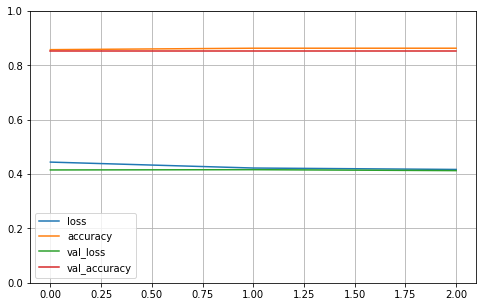

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.7179814 to 0.9743916
Score threshold 0.5


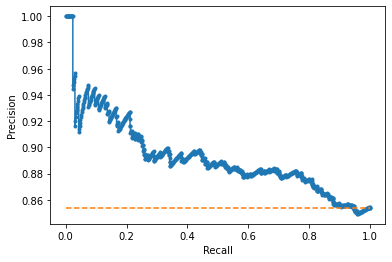

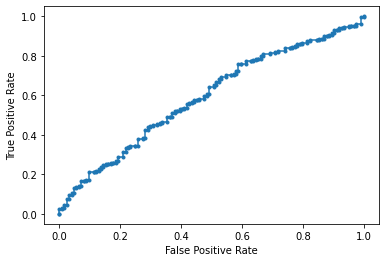

Accuracy: 85.36% Precision: 85.36% Recall: 100.00%
F1: 92.10% MCC: 0.00%
AUPRC: 89.26% AUROC: 59.19%
2023-03-06 23:59:49.425386

2023-03-06 23:59:50.978082
splitting
Fold 1
Discriminator ZERO -1
FIT
2023-03-06 23:59:52.111948
PREDICT
2023-03-06 23:59:57.531124
train class weights 1:0  0.58: 3.51
Train 1:0 2906:482 85.77%
Valid 1:0 742:106 87.50%
Predict 1:0 848:0 100.00%


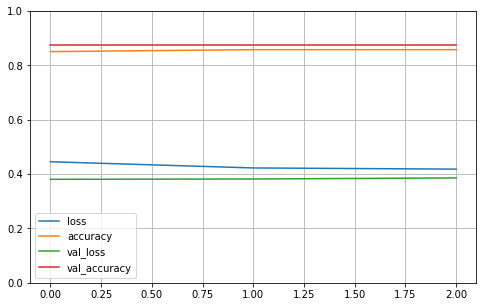

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.5949426 to 0.93784845
Score threshold 0.5


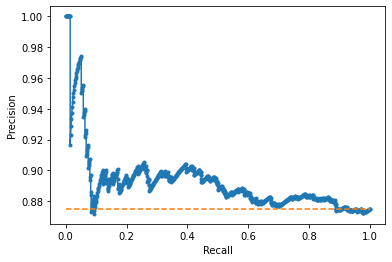

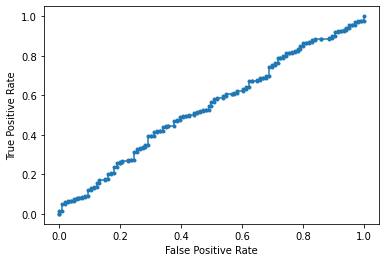

Accuracy: 87.50% Precision: 87.50% Recall: 100.00%
F1: 93.33% MCC: 0.00%
AUPRC: 89.26% AUROC: 54.18%
2023-03-06 23:59:58.446967
Fold 2
Discriminator ZERO -1
FIT
2023-03-07 00:00:01.177147
PREDICT
2023-03-07 00:00:07.984799
train class weights 1:0  0.58: 3.56
Train 1:0 2913:476 85.95%
Valid 1:0 735:112 86.78%
Predict 1:0 847:0 100.00%


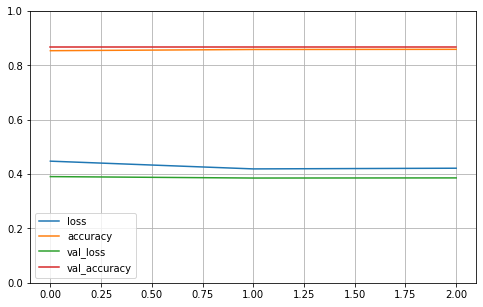

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.7654606 to 0.98061657
Score threshold 0.5


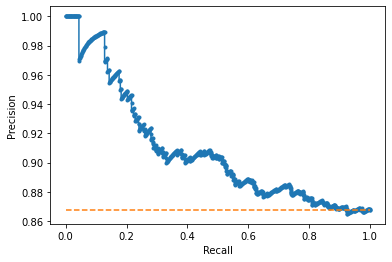

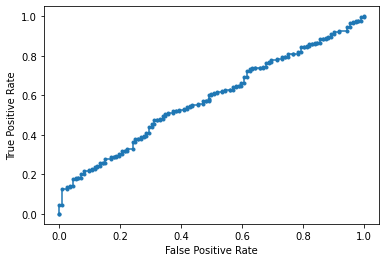

Accuracy: 86.78% Precision: 86.78% Recall: 100.00%
F1: 92.92% MCC: 0.00%
AUPRC: 90.85% AUROC: 58.19%
2023-03-07 00:00:08.900976
Fold 3
Discriminator ZERO -1
FIT
2023-03-07 00:00:11.470888
PREDICT
2023-03-07 00:00:17.534090
train class weights 1:0  0.58: 3.72
Train 1:0 2934:455 86.57%
Valid 1:0 714:133 84.30%
Predict 1:0 847:0 100.00%


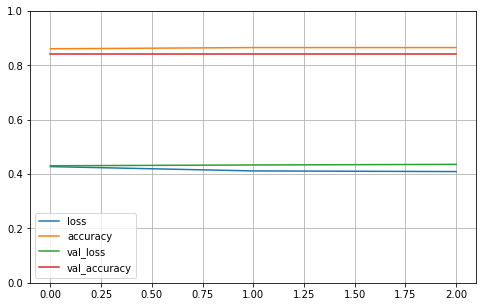

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.6234168 to 0.96034634
Score threshold 0.5


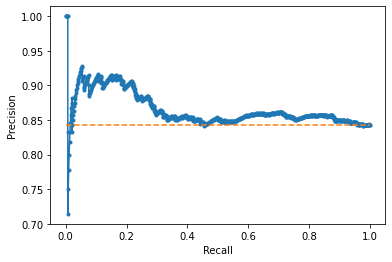

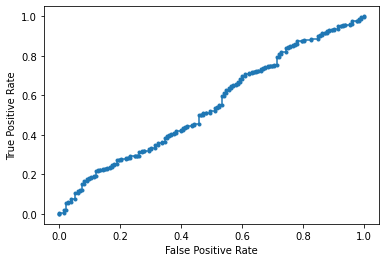

Accuracy: 84.30% Precision: 84.30% Recall: 100.00%
F1: 91.48% MCC: 0.00%
AUPRC: 86.57% AUROC: 54.84%
2023-03-07 00:00:18.428197
Fold 4
Discriminator ZERO -1
FIT
2023-03-07 00:00:21.003249
PREDICT
2023-03-07 00:00:27.290065
train class weights 1:0  0.58: 3.57
Train 1:0 2915:474 86.01%
Valid 1:0 733:114 86.54%
Predict 1:0 847:0 100.00%


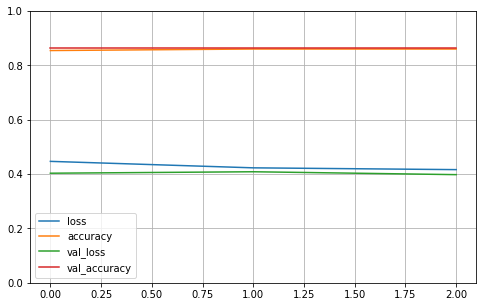

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.7294498 to 0.97377974
Score threshold 0.5


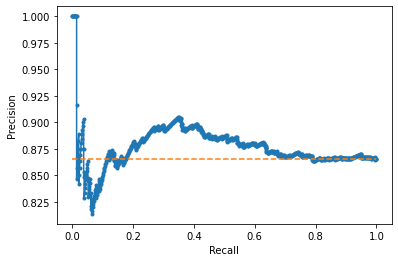

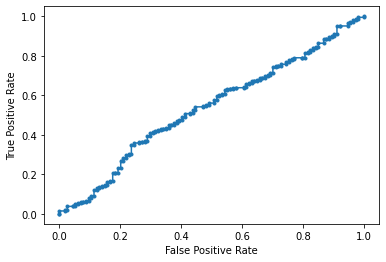

Accuracy: 86.54% Precision: 86.54% Recall: 100.00%
F1: 92.78% MCC: 0.00%
AUPRC: 87.66% AUROC: 53.71%
2023-03-07 00:00:28.632626
Fold 5
Discriminator ZERO -1
FIT
2023-03-07 00:00:31.348091
PREDICT
2023-03-07 00:00:37.600809
train class weights 1:0  0.58: 3.64
Train 1:0 2924:465 86.28%
Valid 1:0 724:123 85.48%
Predict 1:0 847:0 100.00%


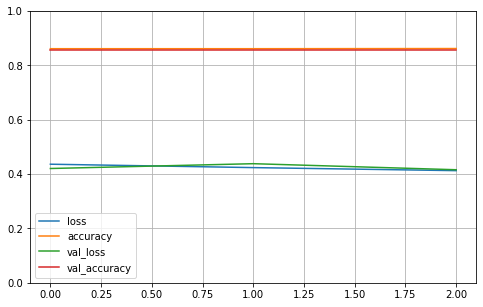

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.79135334 to 0.96725
Score threshold 0.5


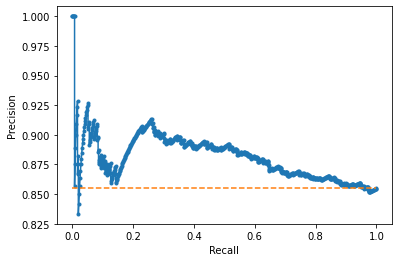

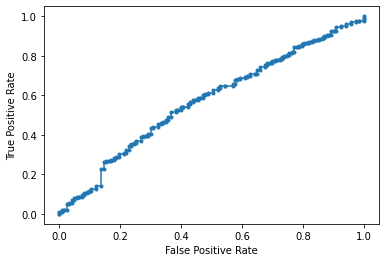

Accuracy: 85.48% Precision: 85.48% Recall: 100.00%
F1: 92.17% MCC: 0.00%
AUPRC: 88.12% AUROC: 57.23%
2023-03-07 00:00:38.455781

Completed cross validation 5 folds 3 epochs
Repeated for a total of 10 folds
 accuracy mean 86.12% std 0.94
 precision mean 86.12% std 0.94
 recall mean 100.00% std 0.00
 F1 mean 92.54% std 0.54
 MCC mean 0.00% std 0.00
 AUPRC mean 88.65% std 1.17
 AUROC mean 56.08% std 1.92

2023-03-07 00:00:39.865322


In [52]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
  total_folds += FOLDS
  cvdo.do_cross_validation()   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(datetime.now())